In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf


In [5]:
import yfinance as yf

# Define the ticker symbol and date range
ticker_symbol = 'AAPL'
start_date = '2024-01-01'
end_date = '2024-12-31'

# Download historical data
aapldf = yf.download(ticker_symbol, start=start_date, end=end_date, multi_level_index= False)

# Use only the close price
aapldf = aapldf[['Close']]

# Display the first few rows of the DataFrame
aapldf.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2024-01-02,184.734985
2024-01-03,183.351776
2024-01-04,181.023163
2024-01-05,180.296707
2024-01-08,184.655365


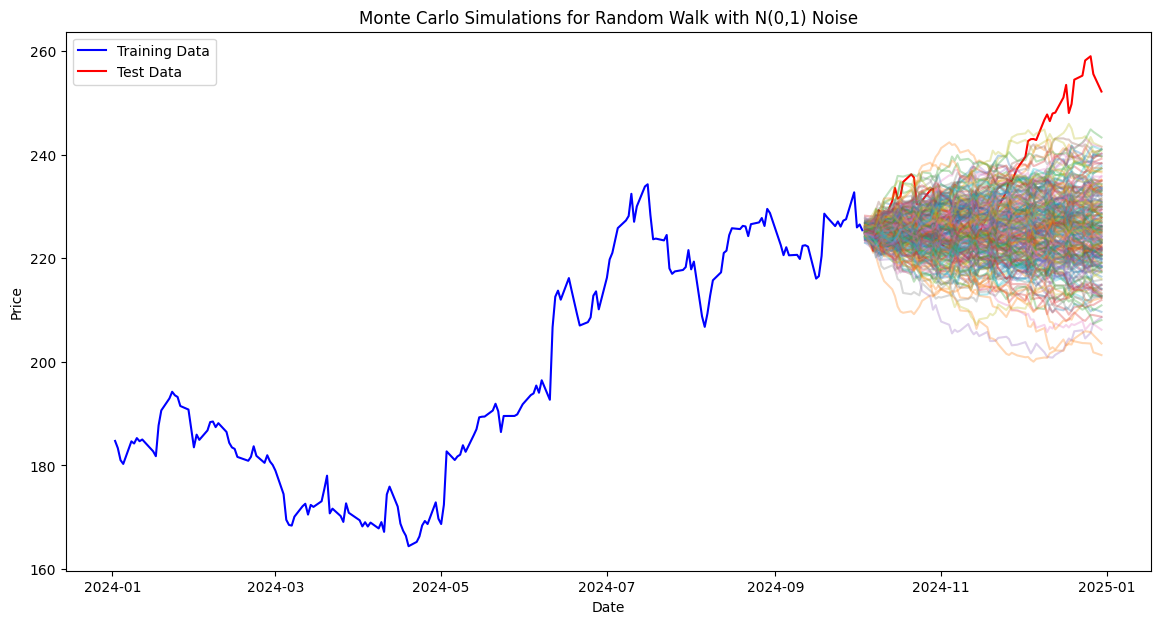

In [16]:
train_data = aapldf.iloc[:-60]
test_data = aapldf.iloc[-60:]

# Parameters
num_simulations = 250
forecast_days = len(test_data)

# Monte Carlo simulation with Gaussian noise for a random walk
simulated_paths = pd.DataFrame(index=test_data.index, columns=range(num_simulations))

# Generate the initial training data time series
initial_values = train_data['Close'].values[-1]

for i in range(num_simulations):
    noise = np.random.normal(0, 1, forecast_days)
    simulated_series = np.cumsum(noise) + initial_values
    simulated_paths.iloc[:, i] = simulated_series

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='red')
for i in range(num_simulations):
    plt.plot(simulated_paths.index, simulated_paths.iloc[:, i], alpha=0.3)

plt.title('Monte Carlo Simulations for Random Walk with N(0,1) Noise')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Use ARIMA to forecast the price

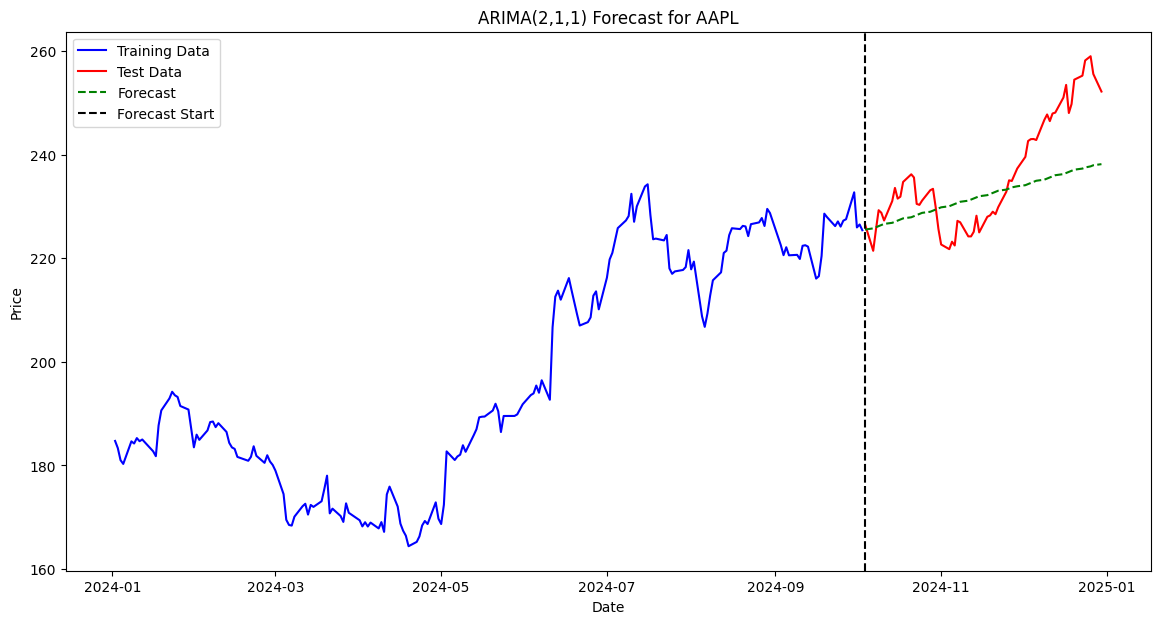

In [39]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Split the data into train_data and test_data
train_data = aapldf[:-60]
test_data = aapldf[-60:]

# Create and fit the ARIMA(2,1,1) model on the training data
model = sm.tsa.ARIMA(train_data['Close'], order=(2, 2, 1))
fitted_model = model.fit()

# Forecast the test data period
forecast = fitted_model.forecast(steps=len(test_data))

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='red')
plt.plot(test_data.index, forecast, label='Forecast', color='green', linestyle='--')
plt.axvline(x=test_data.index[0], color='black', linestyle='--', label='Forecast Start')

plt.title('ARIMA(2,1,1) Forecast for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Add the Markov Simulation to the data

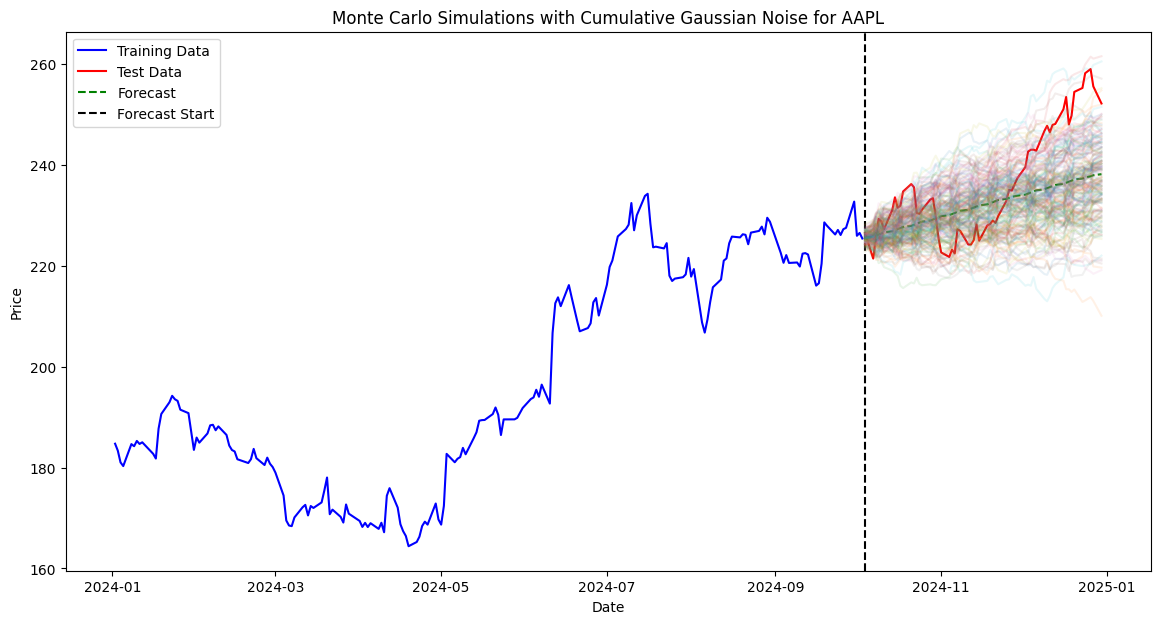

In [40]:
# Assuming 'aapldf' is your DataFrame with the data
train_size = int(len(aapldf) - 60)
train_data = aapldf.iloc[:train_size].copy()
test_data = aapldf.iloc[train_size:].copy()

# Preserve the date index
train_data.index = aapldf.index[:train_size]
test_data.index = aapldf.index[train_size:]

# Create and fit the ARIMA model on the training data
model = sm.tsa.ARIMA(train_data['Close'], order=(2, 2, 1))
fitted_model = model.fit()

# Parameters for Monte Carlo simulation
num_simulations = 200
forecast_days = len(test_data)

# Monte Carlo simulation with cumulative Gaussian noise
simulated_paths = pd.DataFrame(index=test_data.index, columns=range(num_simulations))

for i in range(num_simulations):
    forecast = fitted_model.forecast(steps=forecast_days)
    noise = np.cumsum(np.random.normal(0, 1, forecast_days))
    simulated_series = forecast + noise
    simulated_paths.iloc[:, i] = simulated_series

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='red')
plt.plot(test_data.index, forecast, label='Forecast', color='green', linestyle='--')
plt.axvline(x=test_data.index[0], color='black', linestyle='--', label='Forecast Start')
for i in range(num_simulations):
    plt.plot(simulated_paths.index, simulated_paths.iloc[:, i], alpha=0.1)

plt.title('Monte Carlo Simulations with Cumulative Gaussian Noise for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


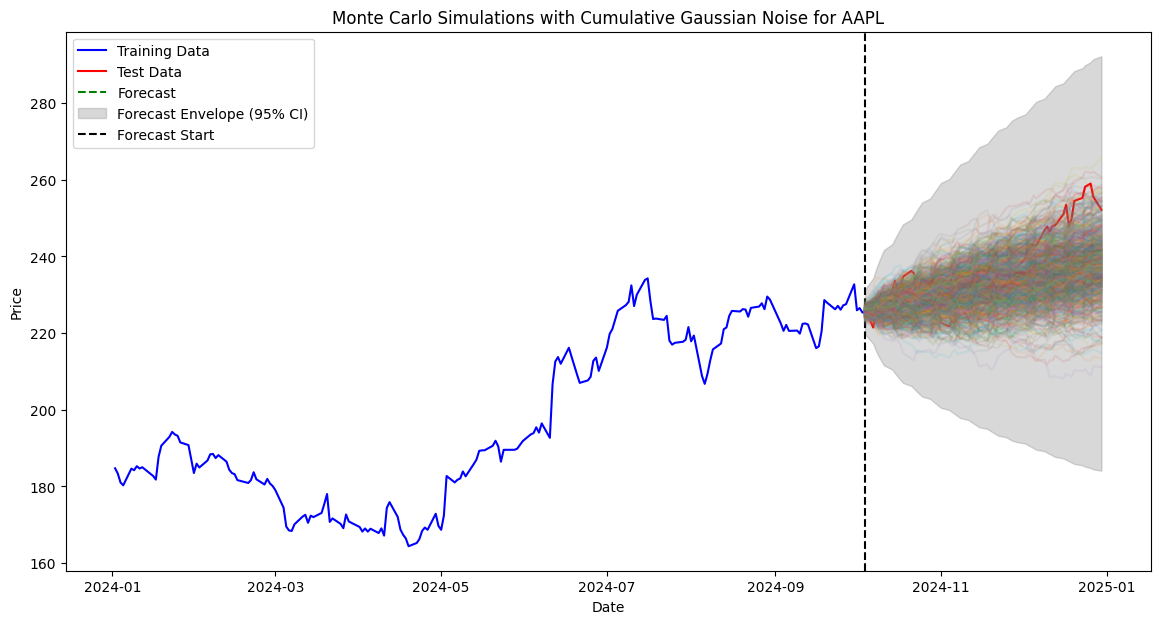

In [41]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Download historical data for Apple Inc. (AAPL) from 2024-01-01 to 2024-12-31
ticker_symbol = 'AAPL'
start_date = '2024-01-01'
end_date = '2024-12-31'
aapldf = yf.download(ticker_symbol, start=start_date, end=end_date)

# Use only the close price
aapldf = aapldf[['Close']]

# Use aapldf[:-60] as train_data and the rest as test_data
train_data = aapldf[:-60]
test_data = aapldf[-60:]

# Create and fit the ARIMA(2, 1, 1) model on the training data
model = sm.tsa.ARIMA(train_data['Close'], order=(2, 2, 1))
fitted_model = model.fit()

# Forecast the test data period
forecast_results = fitted_model.get_forecast(steps=len(test_data))
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)  # 95% confidence interval

# Parameters for Monte Carlo simulation
num_simulations = 1000
forecast_days = len(test_data)

# Monte Carlo simulation with cumulative Gaussian noise
simulated_paths = pd.DataFrame(index=test_data.index, columns=range(num_simulations))

for i in range(num_simulations):
    noise = np.cumsum(np.random.normal(0, 1, forecast_days))
    simulated_series = forecast + noise
    simulated_paths.iloc[:, i] = simulated_series

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='red')
plt.plot(test_data.index, forecast, label='Forecast', color='green', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.3, label='Forecast Envelope (95% CI)')
plt.axvline(x=test_data.index[0], color='black', linestyle='--', label='Forecast Start')
for i in range(num_simulations):
    plt.plot(simulated_paths.index, simulated_paths.iloc[:, i], alpha=0.1)

plt.title('Monte Carlo Simulations with Cumulative Gaussian Noise for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()